## Understand Data

### Download Data

In [ ]:
# Set up imports. Thanks to python it is unnecessarily complicated
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if not IN_COLAB:
    try:
        from helper_functions import PytorchModelTranier
    except ImportError:
        import os
        import sys
        from pathlib import Path
        sys.path.append(str(Path(os.path.abspath('')).parent))
        from helper_functions import PytorchModelTranier
else:
    try:
        from helper_functions import PytorchModelTranier
    except:
        # Get the going_modular scripts
        print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
        !git clone https://github.com/harshankbansal/pytorch-deep-learning
        !mv pytorch-deep-learning/going_modular .
        !mv pytorch-deep-learning/helper_functions.py .
        !mv pytorch-deep-learning/data .
        !rm -rf pytorch-deep-learning
        from helper_functions import PytorchModelTranier
    try:
      from torchinfo import summary
    except ImportError:
      !pip install torchinfo
      from torchinfo import summary

In [ ]:
import torch
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt

RANDOM_SEED=42

In [ ]:
train_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    download=True,
    target_transform=None,
    transform=torchvision.transforms.ToTensor()
)

In [ ]:
test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    download=True,
    target_transform=None,
    transform=torchvision.transforms.ToTensor()
)

### Understanding data

In [ ]:
len(train_data), len(test_data), type(train_data)

(60000, 10000, torchvision.datasets.mnist.FashionMNIST)

In [ ]:
image, label = train_data[0]
label, image

(9,
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.00

In [ ]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
image.shape, type(image), label, type(label)

(torch.Size([1, 28, 28]), torch.Tensor, 9, int)

### Visualize data

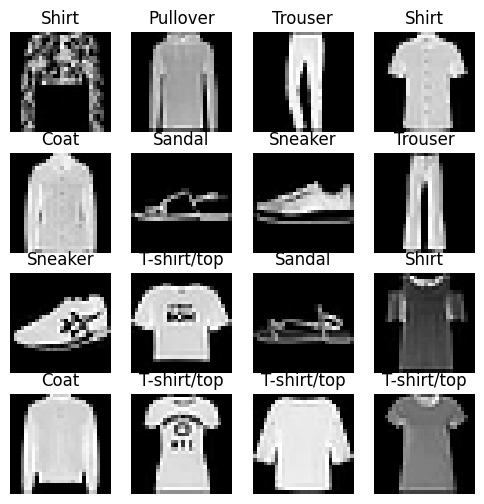

In [ ]:
torch.manual_seed(RANDOM_SEED)
fig = plt.figure(figsize=(6,6))
rows, cols = 4 , 4
for i in range (rows * cols):
    idx = torch.randint(low=0, high=len(train_data)-1, size=(1,)).item()
    image, label = train_data[idx]
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

## Prepare DataLoader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False
)

In [ ]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"len of test and train data loader: {len(train_dataloader), len(test_dataloader)}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001D3ADFA2D80>, <torch.utils.data.dataloader.DataLoader object at 0x000001D3ADBBF3E0>)
len of test and train data loader: (1875, 313)


In [ ]:
idx, (sample_train_batch, sample_train_label_batch) = next(enumerate(train_dataloader))
sample_train_batch.shape, sample_train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Create a baseline model

In [ ]:
from torch import nn
from helper_functions import accuracy_fn, plot_loss_curves
import timer
from tqdm.auto import tqdm
NUM_CLASSES = len(train_data.classes)
HIDDEN_UNITS = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model_0 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=HIDDEN_UNITS),
    nn.Linear(in_features=HIDDEN_UNITS, out_features=NUM_CLASSES)
).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1,
)

model_0_trainer = PytorchModelTranier(
    name="v0-baseline-model",
    model=model_0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    logits_to_pred=lambda logits: torch.softmax(logits, dim=1).argmax(dim=1)
)

In [ ]:
model_0_trainer.train(3)
model_0_trainer.plot_losses()

AttributeError: 'ModelStatistics' object has no attribute 'encode'

In [ ]:
model_0_eval = model_0_trainer.eval()
model_0_eval

In [ ]:
model_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=28*28, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=10)
).to(device)

model_1_trainer = PytorchModelTranier(
    name="v1-with-non-linear-layers-model",
    model=model_1,
    loss_fn=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(
        params=model_1.parameters(),
        lr=0.1,
    ),
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    logits_to_pred=lambda logits: torch.softmax(logits, dim=1).argmax(dim=1)
)

model_1_trainer.train(10)

model_1_eval = model_1_trainer.eval()
print(model_1_eval)

model_1_trainer.plot_losses()

## Create CNN Model

In [ ]:
class FashionMNISTV2(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_shape):
        super().__init__()
        self.conv_l1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_l2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(
                # in_features=0,
                out_features=output_shape,
            )
        )

    def forward(self, x):
        # print("original data shape", x.shape)
        x = self.conv_l1(x)
        # print("shape after conv l1", x.shape)
        x = self.conv_l2(x)
        # print("shape after conv l2", x.shape)
        x = self.classifier(x)
        # print("shape after classifier", x.shape)
        return x

In [ ]:
model_2 = FashionMNISTV2(
    hidden_channels=10,
    input_channels=1,
    output_shape=len(train_data.classes)
).to(device)

model_2_trainer = PytorchModelTranier(
    name="v2-with-conv-layers-model",
    model=model_2,
    loss_fn=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(
        params=model_2.parameters(),
        lr=0.1,
    ),
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    logits_to_pred=lambda logits: torch.softmax(logits, dim=1).argmax(dim=1)
)

# model_2.eval()
# with torch.inference_mode():
#     y_logits = model_2(next(iter(test_dataloader))[0])
# y_logits

In [ ]:
model_2_trainer.train(10)

model_2_eval = model_2_trainer.eval()
print(model_2_eval)

model_2_trainer.plot_losses()